In [3]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns

In [4]:
cmap = sns.color_palette()
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926') # get risk free rate
asset = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926') # construct portfolio with 10 industry in us
print(asset['DESCR'])

10 Industry Portfolios
----------------------

This file was created by CMPT_IND_RETS using the 202109 CRSP database. It contains value- and equal-weighted returns for 10 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (1143 rows x 10 cols)
  1 : Average Equal Weighted Returns -- Monthly (1143 rows x 10 cols)
  2 : Average Value Weighted Returns -- Annual (94 rows x 10 cols)
  3 : Average Equal Weighted Returns -- Annual (94 rows x 10 cols)
  4 : Number of Firms in Portfolios (1143 rows x 10 cols)
  5 : Average Firm Size (1143 rows x 10 cols)
  6 : Sum of BE / Sum of ME (96 rows x 10 cols)
  7 : Value-Weighted Average of BE/ME (96 rows x 10 cols)


In [5]:
# 只取我們需要的時間
df_FF = factor[0].loc['2000':'2020']
df_R = asset[0].loc['2000':'2020']
df_ER = df_R.subtract(df_FF.RF,axis=0) # excessive return

In [7]:
df_ER.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
2000-01,-4.78,-0.87,-8.67,0.91,-4.70,-3.98,-11.36,7.54,6.06,-4.69
2000-02,-6.19,-8.02,-3.94,-5.66,18.19,-3.47,-3.74,-2.92,-7.26,-7.12
2000-03,7.76,10.55,7.48,12.09,3.94,7.52,13.32,0.30,5.77,14.08
2000-04,-1.82,9.28,1.45,-1.92,-10.69,-7.87,-4.47,5.28,7.60,-3.12
2000-05,7.22,-13.24,-1.66,9.54,-10.84,-10.43,-2.77,3.95,3.90,3.40


In [8]:

S = df_R.cov() # sample variance-covariance matrix
R = df_R.mean(axis=0) # sample average return
ER = df_ER.mean(axis=0) # sample average EXCESS RETURN
N = len(ER) # number of assets (10 industry)

# create the GMVP and MSRP in matrix form
ONE = np.ones(len(ER))
GMVP = (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
MSRP = (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)


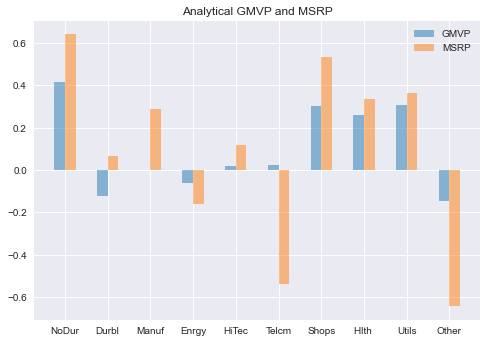

In [9]:
plt.style.use('seaborn')
ind = np.arange(N)
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','MSRP'])
plt.title('Analytical GMVP and MSRP')
plt.show()

What does the above pic shows?   
- Big short selling position in Telcm and Other (really extreme allocation), you may have short selling trading restriction
- Sum of weight is NOT 1 (suggest you have large margin trading on LONG)  
- Compare MSRP and GMVP，GMVP provides more conservatve allocation (check notes)  
JUST by looking the portfolio, we dont need to backtest and we know this allocation is bad. 

In [11]:
def pvar(w, S):
    return (w.T @ S @ w)
def pret(w, ER):
    return (w.T @ ER)
def sharpe(w, ER, S): 
    return -(w.T @ ER)/np.sqrt(w.T @ S @ w) 
    # 要改成負號 -> for computer (因為電腦做的都是 minimize，但我們的目標是 maxmize sharpe ratio)

In [15]:
x0 = np.ones(N)/N # w_i = 0.1 (equal-weighted )
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1}), # w_1 + ... + w_i = 1 weight 家總要是 1 
NGMVP = minimize(pvar, x0, method='SLSQP', args=S, constraints=cons,
options={'disp': True, 'ftol': 1e-9}) # method: check the sciypy reference page
NGMVP

Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.390318779923101
            Iterations: 11
            Function evaluations: 135
            Gradient evaluations: 11


     fun: 9.390318779923101
     jac: array([18.78063774, 18.78063762, 18.78063762, 18.78063762, 18.78063762,
       18.78063762, 18.7806375 , 18.78063762, 18.78063762, 18.78063762])
 message: 'Optimization terminated successfully'
    nfev: 135
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 4.13749772e-01, -1.20916713e-01,  7.84584593e-05, -5.99124443e-02,
        1.70376320e-02,  2.34342157e-02,  3.03490762e-01,  2.61001553e-01,
        3.08067001e-01, -1.46030237e-01])

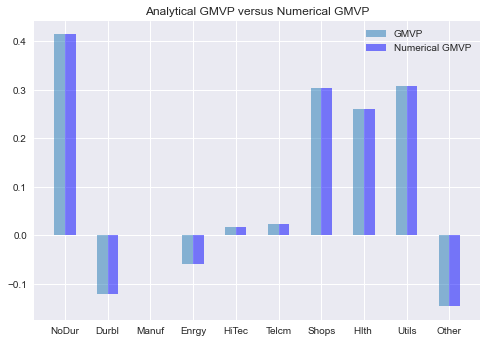

In [16]:
ind = np.arange(N)
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVP.x, width=0.25, alpha=0.5, color='blue')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','Numerical GMVP'])
plt.title('Analytical GMVP versus Numerical GMVP')
plt.show()

In [18]:
# they look idential -> becasue the constraints are the same
# we just do a check to ensure we are asking the right question

NameError: name 'NMSRP' is not defined

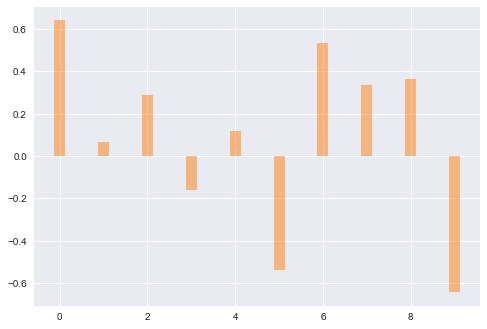

In [19]:
ind = np.arange(N)
plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRP.x, width=0.25, alpha=0.5, color='orange')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['MSRP','Numerical MSRP'])
plt.title('Analytical MSRP versus Numerical MSRP')
plt.show()


In [21]:
from scipy.optimize import Bounds
bounds = Bounds(0, 1) # no margin tardig and short selling
x0 = GMVP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})

# bounds = bound is the only difference 
NGMVPnoSS = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
options={'disp': True, 'ftol': 1e-9}, bounds=bounds)
NGMVPnoSS


Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.677670244601314
            Iterations: 8
            Function evaluations: 91
            Gradient evaluations: 8


     fun: 10.677670244601314
     jac: array([21.35534096, 33.41619253, 25.80424976, 28.39166653, 23.65987611,
       22.79438603, 21.35534108, 21.35534024, 21.35534048, 26.61532676])
 message: 'Optimization terminated successfully'
    nfev: 91
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([3.75368010e-01, 4.35581179e-13, 7.42927243e-14, 1.80881519e-13,
       0.00000000e+00, 0.00000000e+00, 8.67982792e-02, 2.46870691e-01,
       2.90963020e-01, 1.16764618e-13])

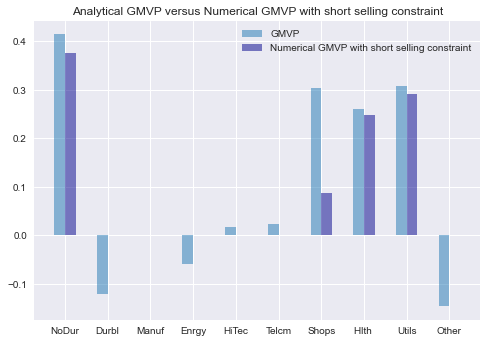

In [22]:
ind = np.arange(N)
plt.bar(ind, GMVP, width=0.25, alpha=0.5, color=cmap[0])
plt.bar(ind + 0.25, NGMVPnoSS.x, width=0.25, alpha=0.5, color='darkblue')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['GMVP','Numerical GMVP with short selling constraint'])
plt.title('Analytical GMVP versus Numerical GMVP with short selling constraint')
plt.show()

# note that there's no short selling anymore

In [23]:
from scipy.optimize import Bounds
bounds = Bounds(0, 1)
x0 = MSRP
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1})
NMSRPnoSS = minimize(sharpe, x0, method='SLSQP', constraints=cons, args=(ER, S),
options={'disp': True, 'ftol': 1e-9}, bounds=bounds)
NMSRPnoSS

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.21830140101314743
            Iterations: 15
            Function evaluations: 165
            Gradient evaluations: 15


     fun: -0.21830140101314743
     jac: array([-2.45869160e-06,  7.86497220e-02,  4.41473275e-02,  1.43232193e-01,
        5.68958651e-02,  1.58268830e-01, -1.41561031e-07, -8.06525350e-07,
        3.87616456e-06,  1.17732631e-01])
 message: 'Optimization terminated successfully'
    nfev: 165
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([3.83522884e-01, 0.00000000e+00, 7.83945933e-17, 1.82145965e-17,
       0.00000000e+00, 1.14959312e-17, 1.51734337e-01, 1.78931853e-01,
       2.85810927e-01, 6.26804381e-18])

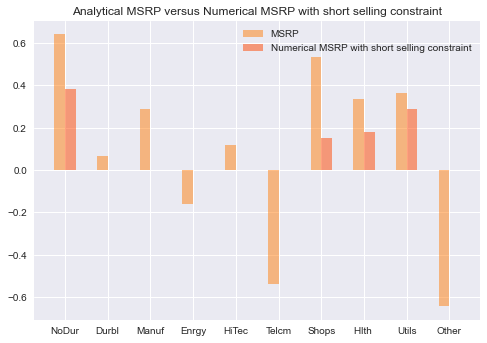

In [24]:
ind = np.arange(N)
plt.bar(ind, MSRP, width=0.25, alpha=0.5, color=cmap[1])
plt.bar(ind + 0.25, NMSRPnoSS.x, width=0.25, alpha=0.5, color='orangered')
plt.xticks(ind + 0.25 / 2, ER.index)
plt.legend(['MSRP','Numerical MSRP with short selling constraint'])
plt.title('Analytical MSRP versus Numerical MSRP with short selling constraint')
plt.show()

# again, there's no short selling anymore
# if no short sell, G and M provide similar result


In [25]:
 GMVPR = pret(GMVP, R)
GMVPSD = np.sqrt(pvar(GMVP, S))
MSRPR = pret(MSRP, R)
MSRPSD = np.sqrt(pvar(MSRP, S))
NGMVPnoSSR = pret(NGMVPnoSS.x, R)
NGMVPnoSSSD = np.sqrt(pvar(NGMVPnoSS.x, S))
NMSRPnoSSR = pret(NMSRPnoSS.x, R)
NMSRPnoSSSD = np.sqrt(pvar(NMSRPnoSS.x, S))
W = np.linspace(-4, 4, 100, endpoint=True)
MVFR = []
MVFSD = []
for u in W:
MVFR.append(u*GMVPR + (1-u)*MSRPR)
MVFSD.append(np.sqrt(u**2 * GMVPSD**2 + (1-u)**2 * MSRPSD**2 + 2*u*(1-u)*np.
,→dot(GMVP, np.dot(S, MSRP))))

NRand = 500
WRand = pd.DataFrame(np.random.uniform(0, 1, size=(NRand, N)))
WRand = WRand.divide(WRand.sum(axis=1), axis=0).to_numpy()
RandR = []
RandSD = []
for i in range(NRand):
RandR.append(pret(WRand[i], R))
RandSD.append(np.sqrt(pvar(WRand[i], S)))
MVFnoSSR = []
MVFnoSSSD = []
TR = np.linspace(0, 1.75, 100, endpoint=True)
for r in TR:
x0 = np.arange(N)/N
cons = ({'type': 'eq', 'fun' : lambda x: np.sum(x) - 1},
{'type': 'eq', 'fun' : lambda x: pret(x, R) - r})
TMP = minimize(pvar, x0, method='SLSQP', constraints=cons, args=S,
options={'disp': False, 'ftol': 1e-9}, bounds=bounds)
MVFnoSSR.append(pret(TMP.x, R))
MVFnoSSSD.append(np.sqrt(pvar(TMP.x, S)))



plt.plot(MVFSD, MVFR, color='orangered', linewidth=2.5, alpha=0.25)
plt.plot(MVFnoSSSD, MVFnoSSR, color='purple', linewidth=2.5, alpha=0.25)
plt.scatter(x=MSRPSD, y=MSRPR, c='red', marker='D', s=50, alpha=1)
plt.scatter(x=GMVPSD, y=GMVPR, c='orange', marker='D', s=50, alpha=1)
plt.scatter(x=NGMVPnoSSSD, y=NGMVPnoSSR, c='blue', marker='x', s=50, alpha=0.5)
plt.scatter(x=NMSRPnoSSSD, y=NMSRPnoSSR, c='green', marker='o', s=50, alpha=0.5)
plt.scatter(x=RandSD, y=RandR, c='gray', marker=',', s=10, alpha=0.25)
plt.xlim([0, 5])
plt.ylim([0, 2])
plt.legend(['MVF','MVFnoSS','MSRP','GMVP','NGMVPnoSS','NMSRPnoSS','Rand'])
plt.title('Analytical MVF versus Numerical MVF with short selling constraint')
plt.show()


IndentationError: expected an indented block (Temp/ipykernel_14840/2578767137.py, line 13)

In [26]:
# define the objective function
# inplment contraints (bound, ...)
# do backtesting

In [27]:
# pdf NO2

In [28]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
cmap = sns.color_palette()
factor = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1-1-1926')
asset = pdr.get_data_famafrench('10_Industry_Portfolios', start='1-1-1926')
start_year = '1980'
end_year = '2021'
df_FF = factor[0].loc[start_year:end_year]
df_R = asset[0].loc[start_year:end_year]
df_ER = df_R.subtract(df_FF.RF,axis=0).shift(1) 
# lag the data one month (bc we are doing backtesting, cant look infront)

In [29]:
df_ER.head()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
Date,,,,,,,,,,
1980-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-02,2.32,8.26,6.26,13.35,6.57,-2.85,0.57,-2.09,0.80,4.71
1980-03,-5.69,-7.20,-3.41,11.69,-4.44,-2.37,-5.70,-5.52,-4.25,-4.22
1980-04,-9.37,-9.95,-12.94,-19.00,-13.87,-3.85,-9.91,-4.05,-7.88,-13.48
1980-05,5.26,-3.17,1.94,5.59,-0.54,6.04,2.03,3.02,10.70,4.82


In [30]:
def gmvp(S):
    ONE = np.ones(len(S))
    return (inv(S) @ ONE) / (ONE.T @ inv(S) @ ONE)
def msrp(ER, S):
    ONE = np.ones(len(S))
    return (inv(S) @ ER) / (ONE.T @ inv(S) @ ER)
def pret(w, R):
    return (w @ R)


In [37]:
import time
start_time = time.time()
from tqdm import tqdm

WSize = 60 # backtest 微度: 5 years
AvgER_rolling = df_ER.rolling(WSize).mean() # rolling histroical averages
CovER_rolling = df_ER.rolling(WSize).cov() # rolling histroical variacne covariance matrix          
Backtest_R = pd.DataFrame(index=df_R.index,columns=['GMVP','MSRP','EW'])
for d in tqdm(df_ER.index):
    ER = AvgER_rolling.loc[d]
    S = CovER_rolling.loc[d]
    R = df_R.loc[d]
    Backtest_R.loc[d,'GMVP'] = pret(gmvp(S), R)
    Backtest_R.loc[d,'MSRP'] = pret(msrp(ER, S), R)
    Backtest_R.loc[:,'EW'] = df_R.mean(axis=1)
    Backtest_R = Backtest_R.loc[(df_R.index[0] + WSize):] # remove first 5 years without gmvp and msrp   

print("---%s seconds ---"% (time.time() - start_time))


# USE parrel programming to do the HW part

ModuleNotFoundError: No module named 'tqdm'

In [34]:
Backtest_R.head()

,GMVP,MSRP,EW
Date,,,
1985-01,0.689861,2.192756,8.121
1985-02,3.857239,3.875767,1.994
1985-03,7.552019,10.488243,0.507
1985-04,-2.159273,-1.184764,-0.599
1985-05,6.808913,6.777654,6.281


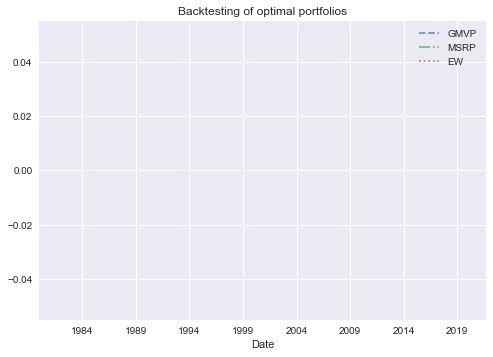

In [39]:
plt.style.use('seaborn')
CumRet = (1 + Backtest_R.divide(100)).cumprod()
CumRet['GMVP'].plot(alpha=0.75, linestyle="--")
CumRet['MSRP'].plot(alpha=0.75, linestyle="-.")
CumRet['EW'].plot(alpha=0.75, linestyle=":")
plt.legend()
plt.title('Backtesting of optimal portfolios')
plt.show()

# MSRP: extreme short saling and margin trading (NOT a good model to use)
# EW > GMVP: recall the last lecture
# Then why bother EM? In HW part, we actually can get result better than EW
